# Popular App Profiles for the App Store and the Google Play 
Yuki Matsumura \
(01/15/2023)


$\hspace{0.5cm}$

The project aims to investigate popular mobile app profiles for the App Store and Google Play. 

I eliminated inaccurate/duplicated data from the original dataset and isolated free apps for English-speaking audiences to study the app profiles for the App Store and Google Play. 

### Data Source

- [App Store](https://dq-content.s3.amazonaws.com/350/AppleStore.csv): Data for a small sample of approximately 7,000 random iOS apps from the App Store (collected in 2017). Information on the data can be found [here](https://www.kaggle.com/ramamet4/app-store-apple-data-set-10k-apps).

- [Google Play](https://dq-content.s3.amazonaws.com/350/googleplaystore.csv): Data for a small sample of about 10,000 random Android apps form Google Play (collected in 2018). Information on the data can be found [here](https://www.kaggle.com/lava18/google-play-store-apps).

### Original Data

I identified the data volume for both the Android and iOS apps after eliminating the data header.

In [1]:
from csv import reader
import colorama
from colorama import Fore

google_file = open('googleplaystore.csv', encoding="utf8")   # Google Play data
apple_file = open('AppleStore.csv', encoding="utf8")   # App Store data

google = reader(google_file)
android_data = list(google)
android = android_data[1:]   # Eliminate header

apple = reader(apple_file)
ios_data = list(apple)
ios = ios_data[1:]   # Eliminate header

print('Original data volume for Android apps: {}'.format(len(android)))  
print('Original data volume iOS apps: {}'.format(len(ios))) 
print('\n')

print('Header for iOS apps: ', '\n', ios_data[0])  
print('\n')

print('Header for Android apps: ', '\n', android_data[0])   

Original data volume for Android apps: 10841
Original data volume iOS apps: 7197


Header for iOS apps:  
 ['id', 'track_name', 'size_bytes', 'currency', 'price', 'rating_count_tot', 'rating_count_ver', 'user_rating', 'user_rating_ver', 'ver', 'cont_rating', 'prime_genre', 'sup_devices.num', 'ipadSc_urls.num', 'lang.num', 'vpp_lic']


Header for Android apps:  
 ['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver']


# Data Cleaning

The flow of the work is as follows:
1. Removing inaccurate data
2. Removing duplicate entries
3. Removing non-English apps
4. Isolating free apps

### 1. Removing Inaccurate Data

The Google Play data for row 10472 has inaccuracy in column 3 (the app is rated 19 out of 5), so I removed the row. Information on the incorrect data was found [here](https://www.kaggle.com/datasets/lava18/google-play-store-apps/discussion/66015).

In [2]:
print('Removed data due to inaccuracy: ', '\n', android[10472]) 
del android[10472]
print('\n')

print(Fore.BLUE + 'Number of Android apps data after removing the incorrect data: {}'.
      format(len(android)))

Removed data due to inaccuracy:  
 ['Life Made WI-Fi Touchscreen Photo Frame', '1.9', '19', '3.0M', '1,000+', 'Free', '0', 'Everyone', '', 'February 11, 2018', '1.0.19', '4.0 and up']


Number of Android apps data after removing the incorrect data: 10840


I checked if there is more inaccurate data in teh Google Play dataset below.

In [3]:
rating_above_5 = 0
for row in android:
    rating = row[2]
    if float(rating) > 5:
        rating_above_5 += 1
        
if rating_above_5 > 0:
    print('There is more data with rating above 5')
    
else:
    print('There is no more data with rating above 5')

There is no more data with rating above 5


### 2. Removing Duplicate Entries

I identified duplicate entries and removed them below.

### App Store

In [4]:
entry_ios = []   # Each iOS app entry
duplicate_entry_ios = []

for row_ios in ios:
    app_ios = row_ios[0]    
    if app_ios not in entry_ios:
        entry_ios.append(app_ios)        
    else:
        duplicate_entry_ios.append(app_ios)
        
print(Fore.BLUE + 'Number of the duplicated entries for the App Store: {}'.
      format(str(len(duplicate_entry_ios))))

Number of the duplicated entries for the App Store: 0


### Google Play

In [5]:
entry = []   # Each Android app entry
duplicate_entry = []

for row in android:
    app = row[0]   
    if app not in entry:
        entry.append(app)       
    else:
        duplicate_entry.append(app)
        
print(Fore.BLUE + 'Number of the duplicated entriefor the Google Play: {}'.
      format(str(len(duplicate_entry))))

Number of the duplicated entriefor the Google Play: 1181


There are no duplicated entries for the App Store data, but Google Play data has 1181 duplicated entries. So I eliminated them by identifying the data with the highest review counts (they contain the latest information) and deleting everything else. 

I first identified the data with the latest information below and then removed the duplicated entries in the following cell.  

In [6]:
reviews_max = {}   # Contains each app name with the highest number of reviews for that app

for row in android:
    app = row[0]   
    num_reviews = float(row[3])    
    if app in reviews_max and reviews_max[app] < num_reviews:
        reviews_max[app] = num_reviews      
    elif app not in reviews_max:
        reviews_max.update({app: num_reviews}) 

In [7]:
android_clean = []   # Cotains cleaned Android dataset
already_added = []   # Keeps a track of Android app names that are already added

for row in android:
    app = row[0]
    num_reviews = float(row[3])    
    if num_reviews == reviews_max[app] and app not in already_added:
        android_clean.append(row)
        already_added.append(app)
        
print(Fore.BLUE + 'Number of android apps after removing the duplicated data: {}'.
      format(len(android_clean))) 

Number of android apps after removing the duplicated data: 9659


### 3. Removing Non-English Apps

I kept only the apps for an English-speaking audience to see a trend in the US markets. For that, I first created a function to identify app names with characters that are not in the set of common English characters. 

The set of common English characters is in the range of 0 to 127 in [American Standard Code for Information Interchange](https://en.wikipedia.org/wiki/ASCII) (ASCII) system.

 I then filtered out non-English apps from the App Store and Google Play based on the app names. Some English apps contain characters that are not in the set of common English characters (such as emojis). To keep those apps, I removed only app names with more than three characters that are outside the range of the common English characters.

In [8]:
def is_english(string):
    '''
    Returns False (Boolean) when the input has more than three characters outside of the set of common English characters. 
    Returns True otherwise.
    '''
    non_english = 0
    
    for char in string:
        if ord(char) > 127:
            non_english += 1
            if non_english > 3:
                return False

    return True

In [9]:
# Filter out non-English apps
    
english_ios = []   # Data of English iOS apps
english_android = []   # Data of English Android apps 


# App Store
for row_ios in ios:
    app_ios = row_ios[1]      
    if is_english(app_ios) == True:
        english_ios.append(row_ios)
        
print(Fore.BLUE + 'Number of iOS apps after filtering out non-English apps: {}'.
      format(len(english_ios)))


# Google Play
for row in android_clean:
    app = row[0]       
    if is_english(app) == True:
        english_android.append(row)
        
print(Fore.BLUE + 'Number of Android apps after filtering out non-English apps: {}'.
      format(len(english_android)))      

Number of iOS apps after filtering out non-English apps: 6183
Number of Android apps after filtering out non-English apps: 9614


### 4. Isolating the Free Apps


The datasets contain free and non-free apps. I removed non-free apps to see the trend of free apps.

In [10]:
free_ios = []   # Cleaned free iOS apps for the English-speaking audience
free_android = []   #  Cleaned free Android apps for the English-speaking audience

# App Store
for row_ios in english_ios:
    price_ios = row_ios[4]   
    if price_ios == '0.0':
        free_ios.append(row_ios)
        
print(Fore.BLUE + 'Number of free ios apps: {}'.format(len(free_ios)))


# Google Play
for row in english_android:
    price = row[7]   
    if price == '0':
        free_android.append(row)
        
print('Number of free android apps: {}'.format(len(free_android)))       

Number of free ios apps: 3222
Number of free android apps: 8864


# Analysis

I compared the most offered genres 

### Most Offered Genres

I then studied most offered genres for iOS and Android apps. For that I first created a function for a frequency table below, and then plotted the share of each genre from my revised data set.

In [11]:
def freq_table(dataset, index):
    '''
    Returns 
        - table (dict): [key] - column name, 'value' - frequency in percentage
        - num_genre (int): volume of the gerne
        - table_sorted_revered (list): list of genre and frequency from the highest frequency
        - genre (list): list of genre (str)
        - frequency (list):  list of frequency in percentage (float)
        
    index is the column for the genre.
    '''
    table = {}   # {column name: frequency[%]}
    total = 0
    
    for row in dataset:
        genre = row[index]   
        if genre not in table: 
            total += 1
            table.update({genre: 1})    
        else:
            total += 1
            table[genre] += 1
                     
    for key in table:
        table[key] = (table[key] / total) * 100
       
          
    table_lo_hi = []   # App genre from the lowest frequency
    
    for key in table:
        key_val_as_tuple = (table[key], key)
        table_lo_hi.append(key_val_as_tuple)

    table_hi_lo = sorted(table_lo_hi, reverse = True)
    
    
    genre = []   # App genre in the sorted order 
    frequency = []   # App frequency in the sorted order

    for entry in table_hi_lo:  
        genre.append(entry[1])
        frequency.append(entry[0])
        
    num_genre = len(table)

               
    return table, num_genre, table_hi_lo, genre, frequency

<font size="3">**App Store**</font>

I used the ```prime_genre``` column for the App Store to plot each genre's offered rate.

In [12]:
prime_genre = freq_table(free_ios, 11)
print(Fore.BLUE + 'Number of genres offered by the App Store: {}'.
      format(prime_genre[1]))

Number of genres offered by the App Store: 23


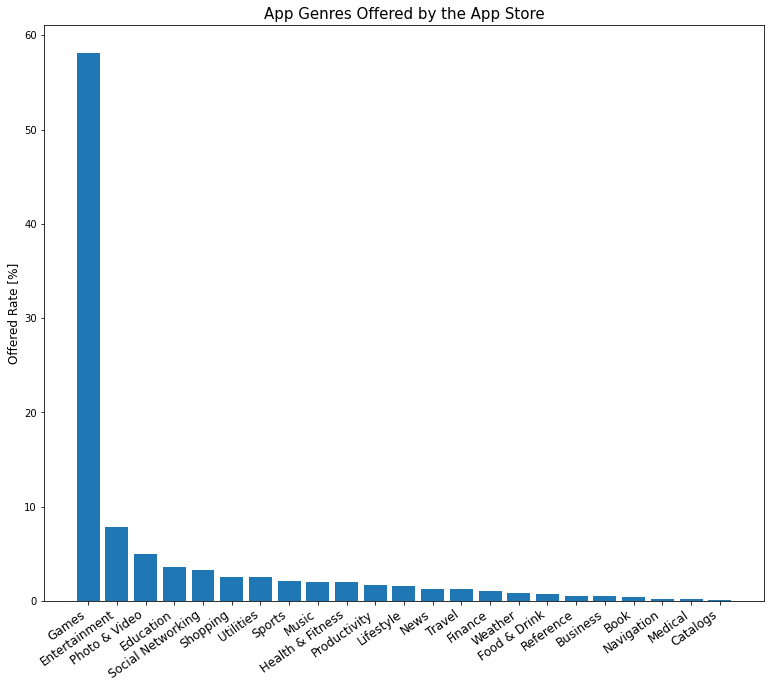

In [13]:
# Plot 
import matplotlib.pyplot as plt
%matplotlib inline

genre_app_store = prime_genre[3]
offered_rate = prime_genre[4]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_axes([0,0,1,1])
ax.bar(genre_app_store, offered_rate)
plt.xticks(rotation=35, ha='right', fontsize = 12)
plt.title('App Genres Offered by the App Store', fontsize = 15)
plt.ylabel('Offered Rate [%]', fontsize = 12)
plt.show()          

```Games``` (58.2%) is the most commonly offered app genre by the App Store. ```Entertainment``` (7.9%) and ```Photo & Video``` (5.0%) follow ```Games```, and they occupy over 70% of the entire genres, suggesting that the App Store focuses on offering more apps for fun purposes. ```Education``` (3.7%) and ```Social Networking``` (3.3%) follow the three top genres.

<font size="3">**Google Play**</font>

The ```Genre``` and ```Category``` columns in the Google Pay dataset both seem relevant for studying the genres of apps offered by Google Play. Since the difference between them is unclear, I first identified the number of genres in ```Genre``` and ```Category```.  

In [14]:
category = freq_table(free_android, 1)
print(Fore.BLUE + 'Number of genres from Category column: {}'.
      format((category[1])))

Number of genres from Category column: 33


In [15]:
genres = freq_table(free_android, 9)
print('Number of genres from Genres column: {}'.format((genres[1])))

Number of genres from Genres column: 114


Based on the number of genres within ```Category``` (33) and ```Genres``` (114), ```Genres``` seems to classify genres more specifically. Since I am interested in the big picture, I looked only into the ```Category``` column to study the trend of apps offered by the App Store and Google Play.

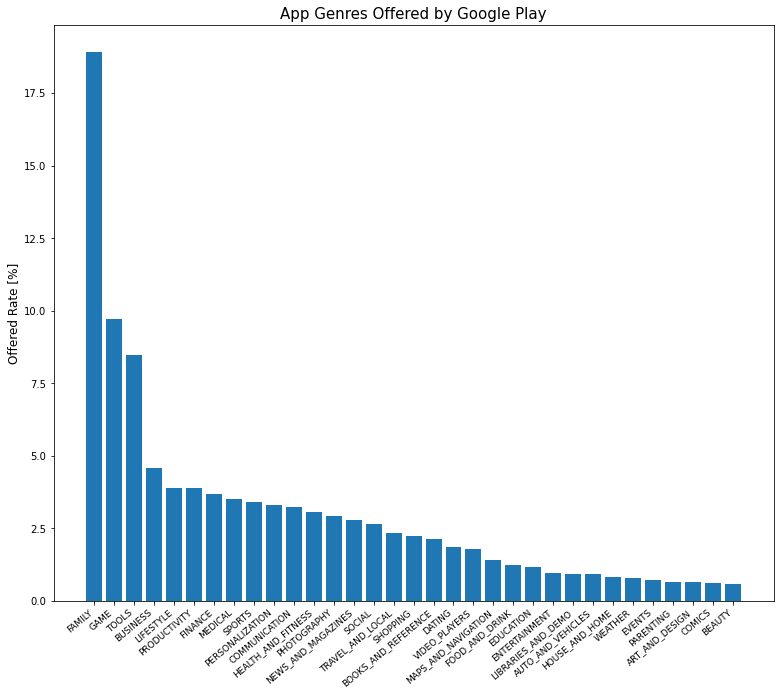

In [16]:
# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_axes([0,0,1,1])
ax.bar(category[3], category[4])
plt.xticks(rotation=40, ha='right', fontsize = 9)
plt.title('App Genres Offered by Google Play', fontsize = 15)
plt.ylabel('Offered Rate [%]', fontsize = 12)
plt.show()         

The top five most offered genres are ```FAMILY``` (18.9%), ```GAME``` (9.7%), ```TOOLS``` (8.5%), ```BUSINESS``` (4.6%), and ```LIFESTYLE``` (3.9%). It is clear that, unlike the App Store, apps for fun purposes are not the main focus of apps offered by Google Play.

### Most Popular Apps 

The installation number for Google Play is in the ```Installs``` column. So I used the column to plot the average download counts for each genre for Google Play. There is no information on installation counts for the App Store, so I used ```rating_count_tot``` instead and studied the average rating counts for each genre for the App Store.

<font size="3">**App Store**</font>

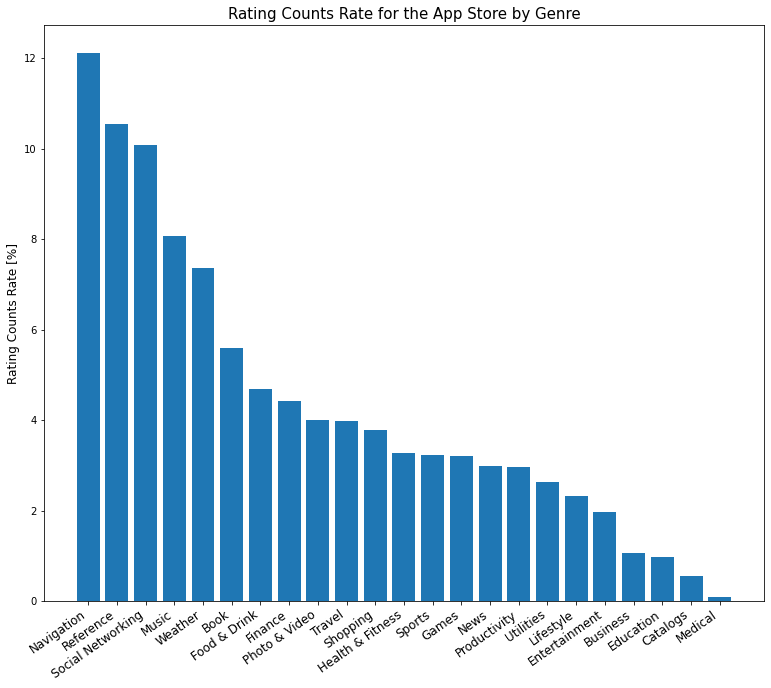

In [17]:
# Identify the average rating counts for each genre

for genre in prime_genre[0]:
    
    total = 0   # Sum of user ratings
    len_genre = 0   # Number of apps for each genre 
    
    for row in free_ios:
        genre_app = row[11]        
        if genre == genre_app:
            app_rating = float(row[5]) 
            total += app_rating
            len_genre += 1 
                
    avg_ratings = total/len_genre   # Average number of user ratings
    prime_genre[0].update({genre: avg_ratings})
    
table_display = []   # Sum of user ratings from the highest rating

for key in prime_genre[0]:
    key_val_as_tuple = (prime_genre[0][key], key)
    table_display.append(key_val_as_tuple)

table_sorted = sorted(table_display, reverse = True)

ios_genre = []   # iOS app from the highest rating
rating = []   # iOS app rating counts

for entry in table_sorted:  
    ios_genre.append(entry[1])
    rating.append(entry[0])
    
rating_rate = []   # iOS app rating count rate
    
for rate in rating:
    count_rate = (rate / sum(rating)) * 100
    rating_rate.append(count_rate)  
    
# Plot 
fig = plt.figure(figsize=(10, 8))
ax = fig.add_axes([0,0,1,1])
ax.bar(ios_genre, rating_rate)
plt.xticks(rotation=35, ha='right', fontsize = 12)
plt.title('Rating Counts Rate for the App Store by Genre', fontsize = 15)
plt.ylabel('Rating Counts Rate [%]', fontsize = 12)
plt.show()  

12.1% of the rating comes from ```Navigation```, 10.6% from ```Reference```, and 10.1% from ```Social Networking```. I cannot make a definite conclusion and infer what app genres are most profitable based on the rating counts rate; however, users seem to care about the quality of apps that are more for practical purposes than for fun purposes. Only 3.2% of the ratings come from ```Games```.

<font size="3">**Google Play**</font>

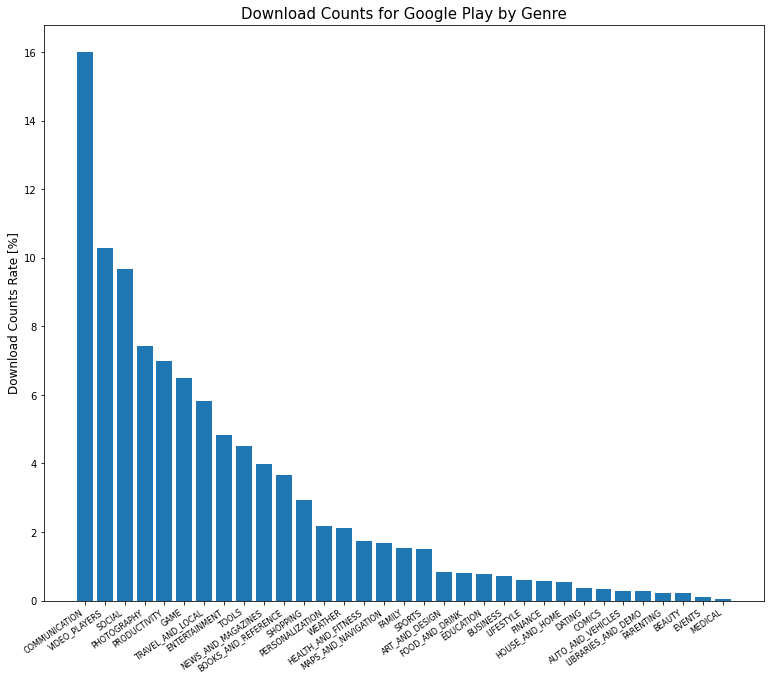

In [18]:
# Identify the average installation counts for each genre

for genre in category[0]: 
    total = 0   # Sum of installation
    len_genre = 0   # Number of apps for each genre 
    for row in free_android:
        genre_app = row[1]   
        if genre_app == genre:
            app_installs = row[5]
            app_installs = app_installs.replace('+', '')
            app_installs = app_installs.replace(',', '')
            total += int(app_installs)
            len_genre += 1 
                
    avg_installs = total/len_genre   # Average number of downloads
    category[0].update({genre: avg_installs})
    
    
table_display = []   # Android app installation count rate

for key in category[0]:
    key_val_as_tuple = (category[0][key], key)
    table_display.append(key_val_as_tuple)

table_sorted = sorted(table_display, reverse = True)

androids_genre = []   # Android app from the highest installation counts
installs = []   # Android app installation counts


for entry in table_sorted:  
    androids_genre.append(entry[1])
    installs.append(entry[0])
    
    
installs_rate = []   # iOS app rating count rate
    
for counts in installs:
    installs_rating = (counts / sum(installs)) * 100
    installs_rate.append(installs_rating)
    
    
# Plot 
fig = plt.figure(figsize=(10, 8))
ax = fig.add_axes([0,0,1,1])
ax.bar(androids_genre, installs_rate)
plt.xticks(rotation=35, ha='right', fontsize = 8)
plt.title('Download Counts for Google Play by Genre', fontsize = 15)
plt.ylabel('Download Counts Rate [%]', fontsize = 12)
plt.show() 

The top three most installed app genres are ```COMMUNICATION``` (16.0%), ```VIDEO_PLAYERS``` (10.3%),  and ```SOCIAL``` (9.7%). Although the most offered genre by Google Play is ```FAMILY```, only 1.5% of the total installations fall into the category.  

# Conclusion

I studied app profiles for the App Store and Google Play to identify profitable free mobile apps in the United States. 

Although more than half of the apps offered by the App Store fall in the Games category,  the App Store users seem to care more about the quality of practical apps such as ```Navigation```, ```Reference```, and ```Social Networking``` based on the rating counts. Though it is hard to infer profitability from it, the App Store should maintain the quality of these apps to keep the users.

Most apps offered by Google Play are in ```FAMILY```, ```GAME```, and ```TOOLS```; however, they occupy only about 12% of the total download counts. Based on the download counts rate, ```COMMUNICATION```, ```VIDEO-PLAYERS```, and ```SOCIAL``` might be more profitable for Google Play. 